https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [55]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [56]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [57]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [58]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            # change here
            if m>f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [59]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [60]:
52+26*26+3

731

In [61]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 987 ms, sys: 56 ms, total: 1.04 s
Wall time: 1.03 s


In [62]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [63]:
# name_count('abcdfaa')

In [64]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [65]:
pre1.shape

(49260, 4)

In [66]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [13]:
# pre0.head()

In [67]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
#     df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:2]
    df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 749)
CPU times: user 563 ms, sys: 56 ms, total: 619 ms
Wall time: 611 ms


In [68]:
pd.options.display.max_columns=100
pre0.head(1)

,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [69]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,Arm,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,okb,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,rev,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,sak,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [70]:
# pre0.to_csv('./preprocessed.csv', index=False)

In [71]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [72]:
# print pre0.columns.values
print pre0.columns.values[2:8]
pre0.head()

['username_split_predict' 'last' 'last_two' 'first' 'first2' 'first3']


,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,Arm,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,okb,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,rev,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,sak,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [73]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,bil,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,Arm,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,okb,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,rev,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,sak,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [74]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:9]
label_encode(pre0, to_be_encoded_cols)

# pre0 =pre0.drop(['username_split_predict'], axis=1)

CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 130 ms


In [75]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1], 
                                                  random_state=7)
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 747), (34482,), (14778, 747), (14778,)]


,username_split_predict,last,last_two,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
1322,0,36,204,26,969,4022,4,0.428571,0.285714,True,True,False,False,2,0,False,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,5.0


In [76]:
# pre0.to_csv('preprocessed.csv',index=False)

In [77]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [78]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.25 s, sys: 295 ms, total: 3.54 s
Wall time: 3.54 s


0.819935038571
0.822438760319
Confusion matrix, without normalization
[[  429  2232]
 [  392 11725]]


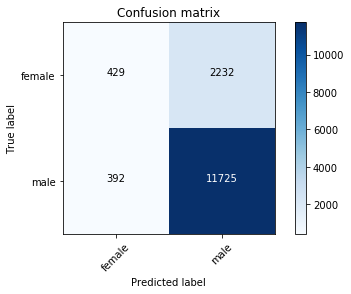

In [79]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [80]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 50.7 s, sys: 430 ms, total: 51.1 s
Wall time: 4.25 s


0.819935038571
0.83177696576
Confusion matrix, without normalization
[[  193  2468]
 [   18 12099]]


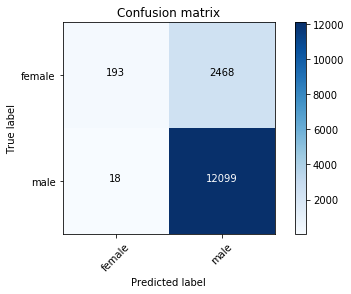

In [81]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [82]:
%%time
fr=RandomForestClassifier(n_estimators=640, min_samples_split=4, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3min 33s, sys: 858 ms, total: 3min 33s
Wall time: 12 s


0.819935038571
0.832724319935
Confusion matrix, without normalization
[[  206  2455]
 [   17 12100]]


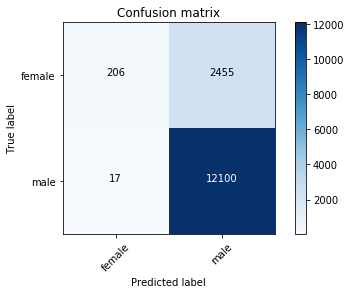

In [83]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [84]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

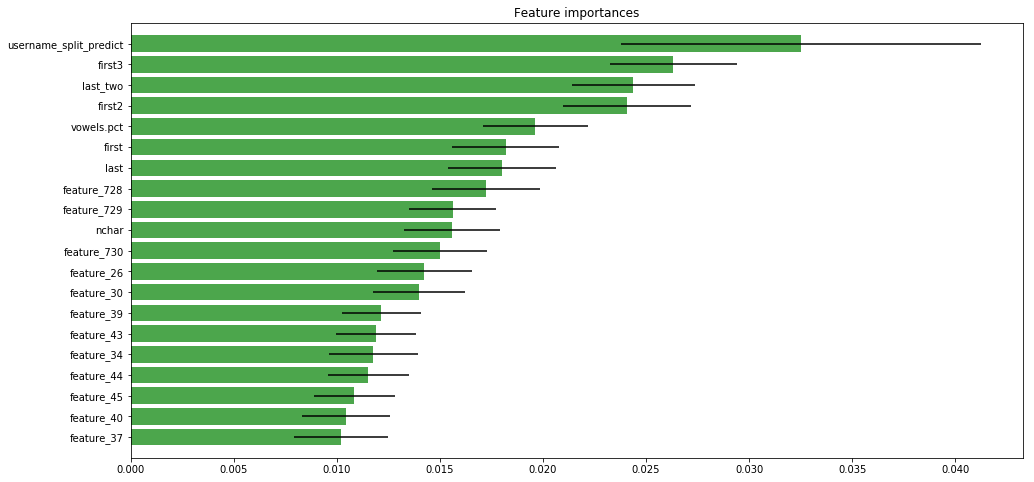

Feature ranking:
1. feature username_split_predict (3.25 %)
2. feature first3 (2.63 %)
3. feature last_two (2.44 %)
4. feature first2 (2.41 %)
5. feature vowels.pct (1.96 %)
6. feature first (1.82 %)
7. feature last (1.80 %)
8. feature feature_728 (1.72 %)
9. feature feature_729 (1.56 %)
10. feature nchar (1.56 %)
11. feature feature_730 (1.50 %)
12. feature feature_26 (1.42 %)
13. feature feature_30 (1.40 %)
14. feature feature_39 (1.22 %)
15. feature feature_43 (1.19 %)
16. feature feature_34 (1.18 %)
17. feature feature_44 (1.15 %)
18. feature feature_45 (1.08 %)
19. feature feature_40 (1.05 %)
20. feature feature_37 (1.02 %)
21. feature digits.pct (0.96 %)
22. feature feature_28 (0.88 %)
23. feature feature_38 (0.88 %)
24. feature feature_33 (0.76 %)
25. feature feature_0 (0.75 %)
26. feature feature_29 (0.75 %)
27. feature feature_4 (0.72 %)
28. feature feature_46 (0.70 %)
29. feature feature_27 (0.70 %)
30. feature digits.num (0.69 %)
31. feature feature_32 (0.68 %)
32. feature f

In [85]:
plotting(fr, X_train, 20)

In [86]:
# RandomForestClassifier?

In [87]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 3s, sys: 349 ms, total: 1min 3s
Wall time: 4.83 s


0.819935038571
0.831709297605
Confusion matrix, without normalization
[[  193  2468]
 [   19 12098]]


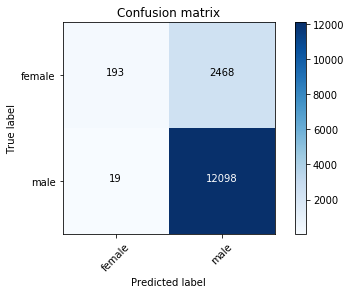

In [88]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.336784409257
Confusion matrix, without normalization
[[2125  536]
 [9265 2852]]


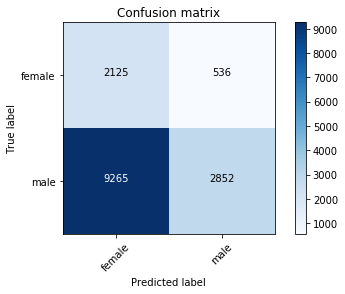

CPU times: user 8.31 s, sys: 2.56 s, total: 10.9 s
Wall time: 8.13 s


In [89]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [90]:
import xgboost as xgb

In [91]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [92]:
d_train.get_label()

array([ 1.,  1.,  1., ...,  0.,  1.,  0.], dtype=float32)

In [93]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [94]:
def female_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    cof = confusion_matrix(y, tmp)
    g_f_c = cof[0][0]
    b_f_c = cof[1][0]
    r_f_c = cof[0][1]
    target = (g_f_c - 1.1*b_f_c)/float(r_f_c)
    return 'female_acc',target
    

In [95]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.853228	test-acc:0.79977
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.867815	test-acc:0.830762
[40]	train-acc:0.88101	test-acc:0.831912
[60]	train-acc:0.897541	test-acc:0.83286
[80]	train-acc:0.91758	test-acc:0.833266
[100]	train-acc:0.934749	test-acc:0.834484
[120]	train-acc:0.951772	test-acc:0.835025
[140]	train-acc:0.966069	test-acc:0.83516
[160]	train-acc:0.976422	test-acc:0.83604
[180]	train-acc:0.984804	test-acc:0.836378
[200]	train-acc:0.990372	test-acc:0.836649
[220]	train-acc:0.993504	test-acc:0.836852
[240]	train-acc:0.995998	test-acc:0.837393
[260]	train-acc:0.997535	test-acc:0.837123
[280]	train-acc:0.998637	test-acc:0.836581
[300]	train-acc:0.999391	test-acc:0.837123
[320]	train-acc:0.999623	test-acc:0.83692
[340]	train-acc:0.999681	test-acc:0.83692
[360]	train-acc:0.999797	test-acc:0.836378
Stopping. Best iteration:
[265]	train-acc:0.997738	test

'!!! used 81.29 s'

accuracy 0.836581404791
statistic
male      14180
female      598
dtype: int64
Confusion matrix, without normalization
[[  422  2239]
 [  176 11941]]


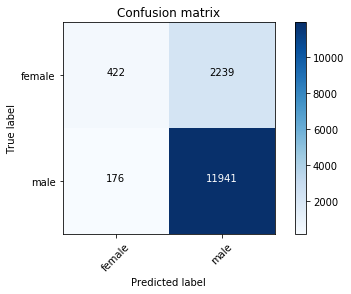

In [97]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

#### on accuracy 

### tune

In [98]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [99]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [100]:
6210.0/28272

0.21965195246179967

In [101]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [102]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.836842	test-acc:0.822168
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 200 rounds.
[20]	train-acc:0.842498	test-acc:0.828394
[40]	train-acc:0.844905	test-acc:0.828529
[60]	train-acc:0.844876	test-acc:0.829003
[80]	train-acc:0.846645	test-acc:0.8288
[100]	train-acc:0.848153	test-acc:0.828597
[120]	train-acc:0.849864	test-acc:0.829476
[140]	train-acc:0.851053	test-acc:0.830085
[160]	train-acc:0.853141	test-acc:0.830221
[180]	train-acc:0.854591	test-acc:0.830627
[200]	train-acc:0.856186	test-acc:0.830897
[220]	train-acc:0.857723	test-acc:0.831777
[240]	train-acc:0.859231	test-acc:0.832183
[260]	train-acc:0.860652	test-acc:0.832386
[280]	train-acc:0.861609	test-acc:0.832115
[300]	train-acc:0.863349	test-acc:0.832115
[320]	train-acc:0.865147	test-acc:0.83198
[340]	train-acc:0.867061	test-acc:0.831845
[360]	train-acc:0.868859	test-acc:0.832251
[380]	train-acc:0.870831	test-acc:0.832183
[400]	t

'!!! used 307.74 s'

accuracy 0.837461090811
statistic
male      14213
female      565
dtype: int64
Confusion matrix, without normalization
[[  412  2249]
 [  153 11964]]


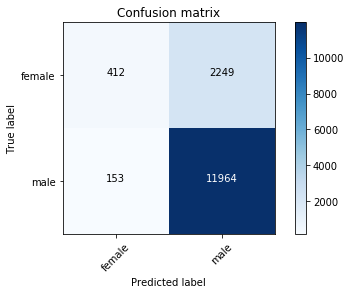

In [103]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [104]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
136,last_two,50597
269,first2,38280
393,vowels.pct,38206
270,first3,31124
410,last,29962
413,nchar,22441
502,feature_728,21956
501,feature_729,21066
514,feature_30,20959
54,feature_26,20165


In [105]:
# pd.DataFrame.plot?

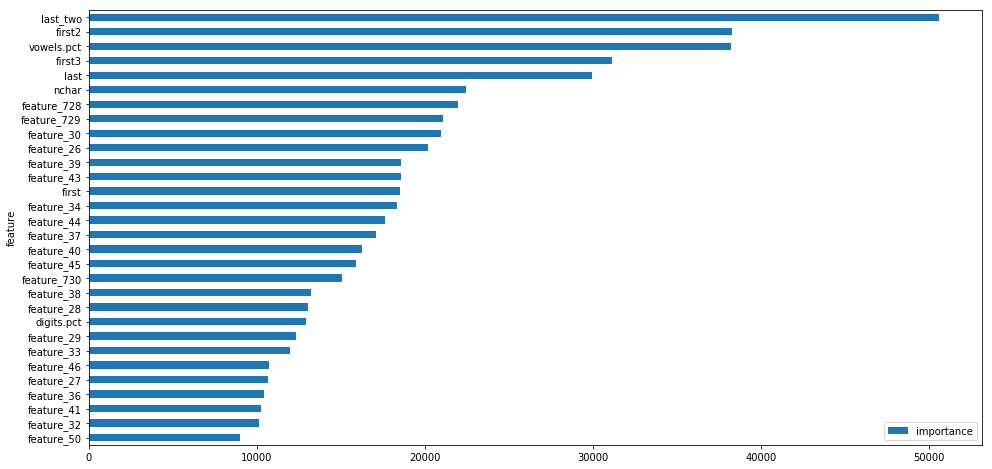

In [106]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [120]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,male,okbookman


### other sklearn models

In [270]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [140]:
# svm = SVC()
# svm

In [141]:
# %%time
# # svm.fit(X_train, y_train)

In [142]:
# from sklearn.neural_network import MLPClassifier

In [143]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [145]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [146]:
# pd.Series(neur_prd).value_counts()

In [147]:
# accuracy_score(y_test,neur_prd)

In [148]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [149]:
# from sklearn.naive_bayes import BernoulliNB

In [150]:
# nb = BernoulliNB()
# nb

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()